In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import *

appName = "case_study1"
master = "local"

conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession.builder.getOrCreate()

df = (spark.read
      .format("csv")
      .option("inferSchema", "true")
      .option("header","true")
      .load('/Users/zhuohenghan/Downloads/loans_full_schema.csv')
      )

In [2]:
df.printSchema()

root
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- state: string (nullable = true)
 |-- homeownership: string (nullable = true)
 |-- annual_income: double (nullable = true)
 |-- verified_income: string (nullable = true)
 |-- debt_to_income: string (nullable = true)
 |-- annual_income_joint: string (nullable = true)
 |-- verification_income_joint: string (nullable = true)
 |-- debt_to_income_joint: string (nullable = true)
 |-- delinq_2y: integer (nullable = true)
 |-- months_since_last_delinq: string (nullable = true)
 |-- earliest_credit_line: integer (nullable = true)
 |-- inquiries_last_12m: integer (nullable = true)
 |-- total_credit_lines: integer (nullable = true)
 |-- open_credit_lines: integer (nullable = true)
 |-- total_credit_limit: integer (nullable = true)
 |-- total_credit_utilized: integer (nullable = true)
 |-- num_collections_last_12m: integer (nullable = true)
 |-- num_historical_failed_to_pay: integer (nullable = true)
 |-- m

In [3]:
df.count()

10000

In [4]:
len(df.columns)

55

In [5]:
df = (df.withColumn('emp_length_int', df['emp_length'].cast('int')).drop('emp_length')
      .withColumn('debt_to_income_int', df['debt_to_income'].cast('int')).drop('debt_to_income')
      .withColumn('months_since_last_credit_inquiry_int', df['months_since_last_credit_inquiry'].cast('int')).drop('months_since_last_credit_inquiry')
      .withColumn('num_accounts_120d_past_due_int', df['num_accounts_120d_past_due'].cast('int')).drop('num_accounts_120d_past_due')
              .distinct())

First of all, we are going to check missing values. We can find that variables emp_title, emp_length, debt_to_income, annual_income_joint, verification_income_joint, debt_to_income_joint, months_since_last_delinq, months_since_90d_late, months_since_last_credit_inquiry, num_accounts_120d_past_due have missing values. There are 7715, 5658, 8505, 8505, and 8505 missing values in annual_income_joint, verification_income_joint, debt_to_income_joint, months_since_last_delinq, months_since_90d_late, respectively, which are more than half of the total rows, we are going to drop these variables.

In [6]:
df.select([count(when(col(c) == 'NA', c)).alias(c) for c in df.columns]).show()

+---------+-----+-------------+-------------+---------------+-------------------+-------------------------+--------------------+---------+------------------------+--------------------+------------------+------------------+-----------------+------------------+---------------------+------------------------+----------------------------+---------------------+-----------------------+----------------------------+----------------------------+-------------------+-------------------------+-------------------------+-------------------------+-----------------+---------------------+--------------------+-----------------------+-----------------+----------------------------+---------+----------------------+------------+----------------+-----------+----+-------------+-----------+-----+---------+-----------+-----------+----------------------+-------------------+-------+----------+--------------+-------------+--------------+--------------+------------------+------------------------------------+--------

In [7]:
new_df = df.drop('annual_income_joint','debt_to_income_joint', 'months_since_last_delinq', 'months_since_90d_late')

In [8]:
new_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in new_df.columns]).show()

+---------+-----+-------------+-------------+---------------+-------------------------+---------+--------------------+------------------+------------------+-----------------+------------------+---------------------+------------------------+----------------------------+-----------------------+----------------------------+----------------------------+-------------------+-------------------------+-------------------------+-------------------------+-----------------+---------------------+--------------------+-----------------------+-----------------+----------------------------+---------+----------------------+------------+----------------+-----------+----+-------------+-----------+-----+---------+-----------+-----------+----------------------+-------------------+-------+----------+--------------+-------------+--------------+--------------+------------------+------------------------------------+------------------------------+
|emp_title|state|homeownership|annual_income|verified_income|ver

In [9]:
new_df_without_NA = new_df.drop('verification_income_joint')

For the column emp_length_int, debt_to_income_int, months_since_last_credit_inquiry_int, and num_accounts_120d_past_due_int, I am going to impute with mean.

In [10]:
filled_df = new_df_without_NA.fillna(-1,['emp_length_int', 'debt_to_income_int', 'months_since_last_credit_inquiry_int', 'num_accounts_120d_past_due_int'])

imputer = Imputer (
inputCols=['emp_length_int', 'debt_to_income_int', 'months_since_last_credit_inquiry_int', 'num_accounts_120d_past_due_int'],
outputCols=["{}_imputed".format(c) for c in ['emp_length_int', 'debt_to_income_int', 'months_since_last_credit_inquiry_int', 'num_accounts_120d_past_due_int']]
).setStrategy("mean").setMissingValue(-1)

imputed_df = imputer.fit(filled_df).transform(filled_df)
imputed_df_with_dropped_columns = imputed_df.drop('emp_length_int', 'debt_to_income_int', 'months_since_last_credit_inquiry_int', 'num_accounts_120d_past_due_int')

cleaned_df = (imputed_df_with_dropped_columns.withColumnRenamed('emp_length_int_imputed','emp_length')
                    .withColumnRenamed('debt_to_income_int_imputed','debt_to_income')
                    .withColumnRenamed('months_since_last_credit_inquiry_int_imputed','months_since_last_credit_inquiry')
                    .withColumnRenamed('num_accounts_120d_past_due_int_imputed','num_accounts_120d_past_due'))
cleaned_df.show(1)

+-----------+-----+-------------+-------------+---------------+---------+--------------------+------------------+------------------+-----------------+------------------+---------------------+------------------------+----------------------------+-----------------------+----------------------------+----------------------------+-------------------+-------------------------+-------------------------+-------------------------+-----------------+---------------------+--------------------+-----------------------+-----------------+----------------------------+---------+----------------------+------------+----------------+-----------+----+-------------+-----------+-----+---------+-----------+-----------+----------------------+-------------------+-------+----------+--------------+-------------+--------------+----------+--------------+--------------------------------+--------------------------+
|  emp_title|state|homeownership|annual_income|verified_income|delinq_2y|earliest_credit_line|inquiries_

In [11]:
numeric_columns = [column[0] for column in cleaned_df.dtypes if column[1]=='int' or column[1]=='double']
cleaned_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in numeric_columns]).show(vertical=True)

-RECORD 0-------------------------------
 annual_income                    | 0   
 delinq_2y                        | 0   
 earliest_credit_line             | 0   
 inquiries_last_12m               | 0   
 total_credit_lines               | 0   
 open_credit_lines                | 0   
 total_credit_limit               | 0   
 total_credit_utilized            | 0   
 num_collections_last_12m         | 0   
 num_historical_failed_to_pay     | 0   
 current_accounts_delinq          | 0   
 total_collection_amount_ever     | 0   
 current_installment_accounts     | 0   
 accounts_opened_24m              | 0   
 num_satisfactory_accounts        | 0   
 num_accounts_30d_past_due        | 0   
 num_active_debit_accounts        | 0   
 total_debit_limit                | 0   
 num_total_cc_accounts            | 0   
 num_open_cc_accounts             | 0   
 num_cc_carrying_balance          | 0   
 num_mort_accounts                | 0   
 account_never_delinq_percent     | 0   
 tax_liens      

After dealing with the missing values, I plot the correlation matrix to check high correlated variables. I am going to drop installment, balance, tax_liens, paid_principal, and num_accounts_120d_past_due since they are highly correlated with others.

In [12]:
correlation_matrix = cleaned_df.toPandas().corr()
print(correlation_matrix)

                                  annual_income  delinq_2y  \
annual_income                          1.000000   0.052236   
delinq_2y                              0.052236   1.000000   
earliest_credit_line                  -0.156001  -0.078109   
inquiries_last_12m                     0.090119   0.003152   
total_credit_lines                     0.210163   0.068040   
open_credit_lines                      0.176788   0.013050   
total_credit_limit                     0.516703   0.053373   
total_credit_utilized                  0.406370   0.001855   
num_collections_last_12m              -0.008330   0.077680   
num_historical_failed_to_pay           0.025976  -0.026574   
current_accounts_delinq                0.001665   0.026097   
total_collection_amount_ever          -0.000080   0.011577   
current_installment_accounts           0.096542   0.005762   
accounts_opened_24m                    0.094446  -0.062541   
num_satisfactory_accounts              0.176957   0.012409   
num_acco

In [13]:
non_correlated_df = cleaned_df.drop('installment','balance', 'tax_liens', 'paid_principal', 'num_accounts_120d_past_due')
non_correlated_df.printSchema()  

root
 |-- emp_title: string (nullable = true)
 |-- state: string (nullable = true)
 |-- homeownership: string (nullable = true)
 |-- annual_income: double (nullable = true)
 |-- verified_income: string (nullable = true)
 |-- delinq_2y: integer (nullable = true)
 |-- earliest_credit_line: integer (nullable = true)
 |-- inquiries_last_12m: integer (nullable = true)
 |-- total_credit_lines: integer (nullable = true)
 |-- open_credit_lines: integer (nullable = true)
 |-- total_credit_limit: integer (nullable = true)
 |-- total_credit_utilized: integer (nullable = true)
 |-- num_collections_last_12m: integer (nullable = true)
 |-- num_historical_failed_to_pay: integer (nullable = true)
 |-- current_accounts_delinq: integer (nullable = true)
 |-- total_collection_amount_ever: integer (nullable = true)
 |-- current_installment_accounts: integer (nullable = true)
 |-- accounts_opened_24m: integer (nullable = true)
 |-- num_satisfactory_accounts: integer (nullable = true)
 |-- num_accounts_30d_

<AxesSubplot:>

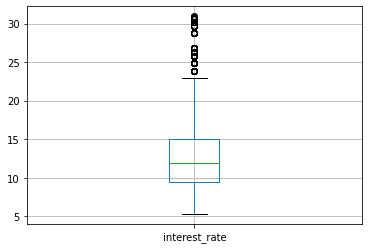

In [30]:
non_correlated_df[['interest_rate']].toPandas().boxplot()

Then, I removed all outliers for each numeric variables so that the model will not be affected by those extreme values.

In [14]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int' or column[1]=='double']

    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)

        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    
    df = df.withColumn('total_outliers',reduce(column_add, (df[col] for col in selected_columns)))
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [15]:
df_with_substituted_na_and_outliers = find_outliers(non_correlated_df)
df_with_substituted_na_and_outliers.show(1, vertical=True)

-RECORD 0----------------------------------------
 emp_title                        | rx lab tecg  
 state                            | FL           
 homeownership                    | RENT         
 annual_income                    | 33000.0      
 verified_income                  | Not Verified 
 delinq_2y                        | 0            
 earliest_credit_line             | 2005         
 inquiries_last_12m               | 0            
 total_credit_lines               | 12           
 open_credit_lines                | 9            
 total_credit_limit               | 19900        
 total_credit_utilized            | 5546         
 num_collections_last_12m         | 0            
 num_historical_failed_to_pay     | 0            
 current_accounts_delinq          | 0            
 total_collection_amount_ever     | 2243         
 current_installment_accounts     | 0            
 accounts_opened_24m              | 5            
 num_satisfactory_accounts        | 9            


In [16]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

stage_1 = StringIndexer(inputCol= 'state', outputCol= 'state_index', handleInvalid="keep")
stage_2 = StringIndexer(inputCol= 'homeownership', outputCol= 'homeownership_index', handleInvalid="keep")
stage_3 = StringIndexer(inputCol= 'verified_income', outputCol= 'verified_income_index', handleInvalid="keep")
stage_4 = StringIndexer(inputCol= 'loan_purpose', outputCol= 'loan_purpose_index', handleInvalid="keep")
stage_5 = StringIndexer(inputCol= 'application_type', outputCol= 'application_type_index', handleInvalid="keep")
stage_6 = StringIndexer(inputCol= 'sub_grade', outputCol= 'sub_grade_index', handleInvalid="keep")
stage_7 = StringIndexer(inputCol= 'loan_status', outputCol= 'loan_status_index', handleInvalid="keep")
stage_8 = StringIndexer(inputCol= 'initial_listing_status', outputCol= 'initial_listing_status_index', handleInvalid="keep")
stage_9 = StringIndexer(inputCol= 'disbursement_method', outputCol= 'disbursement_method_index', handleInvalid="keep")


# define stage 4 : one hot encode the numeric columns
stage_10 = OneHotEncoder(inputCols=['state_index', 'homeownership_index', 'verified_income_index', 'loan_purpose_index',
                                   'application_type_index', 'sub_grade_index', 'loan_status_index', 'initial_listing_status_index',
                                   'disbursement_method_index'], 
                        outputCols=['state_encoded','homeownership_encoded','verified_income_encoded',
                                   'loan_purpose_encoded','application_type_encoded', 'sub_grade_encoded',
                                   'loan_status_encoded', 'initial_listing_status_encoded','disbursement_method_encoded'])

# setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, stage_5, stage_6, stage_7, stage_8, stage_9, stage_10])

# fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(df_with_substituted_na_and_outliers)
encoded_df = pipeline_model.transform(df_with_substituted_na_and_outliers)

# view the transformed data
encoded_df.printSchema()

root
 |-- emp_title: string (nullable = true)
 |-- state: string (nullable = true)
 |-- homeownership: string (nullable = true)
 |-- annual_income: double (nullable = true)
 |-- verified_income: string (nullable = true)
 |-- delinq_2y: integer (nullable = true)
 |-- earliest_credit_line: integer (nullable = true)
 |-- inquiries_last_12m: integer (nullable = true)
 |-- total_credit_lines: integer (nullable = true)
 |-- open_credit_lines: integer (nullable = true)
 |-- total_credit_limit: integer (nullable = true)
 |-- total_credit_utilized: integer (nullable = true)
 |-- num_collections_last_12m: integer (nullable = true)
 |-- num_historical_failed_to_pay: integer (nullable = true)
 |-- current_accounts_delinq: integer (nullable = true)
 |-- total_collection_amount_ever: integer (nullable = true)
 |-- current_installment_accounts: integer (nullable = true)
 |-- accounts_opened_24m: integer (nullable = true)
 |-- num_satisfactory_accounts: integer (nullable = true)
 |-- num_accounts_30d_

In [17]:
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(
    inputCols=['state_encoded','homeownership_encoded','verified_income_encoded','loan_purpose_encoded',
               'application_type_encoded', 'sub_grade_encoded','loan_status_encoded','initial_listing_status_encoded',
               'disbursement_method_encoded','annual_income','earliest_credit_line','total_credit_lines','open_credit_lines',
               'total_credit_limit','total_credit_utilized','total_collection_amount_ever','num_satisfactory_accounts',
               'num_active_debit_accounts','total_debit_limit','num_total_cc_accounts','num_open_cc_accounts','num_cc_carrying_balance',
               'account_never_delinq_percent','loan_amount','term','paid_total','paid_interest','paid_late_fees','emp_length',         
               'debt_to_income','months_since_last_credit_inquiry'], 
    outputCol="vectorized_features")

assembled_df = vector_assembler.transform(encoded_df)

In [18]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')

scaled_model = standard_scaler.fit(assembled_df)
scaled_df = scaled_model.transform(assembled_df)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 vectorized_features | (134,[3,51,54,63,68,77,102,109,110,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,131,132,133],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,33000.0,2005.0,12.0,9.0,19900.0,5546.0,2243.0,9.0,2.0,6600.0,12.0,9.0,5.0,100.0,6000.0,36.0,965.27,239.32,5.

In [19]:
train, test = scaled_df.randomSplit([0.8, 0.2], seed = 123)

I am going to apply linear regression model and random forest regressor model.

In [20]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol = 'features', labelCol = 'interest_rate', predictionCol='prediction', 
                      maxIter=100, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(train)
lr_predictions = lrModel.transform(test)

lr_evaluator = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='interest_rate',metricName='r2')
print('R Squared (R2) on test data = %g' % lr_evaluator.evaluate(lr_predictions))

test_result = lrModel.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

R Squared (R2) on test data = 0.923513
Root Mean Squared Error (RMSE) on test data = 1.38606


In [44]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol="interest_rate", featuresCol="features")
rf_evaluator = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='interest_rate',metricName='r2')
print('R Squared (R2) on test data = %g' % rf_evaluator.evaluate(rf_predictions))

evaluator = RegressionEvaluator(labelCol="interest_rate", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rf_predictions)
print('R Squared (R2) on test data = %g' % rmse)

R Squared (R2) on test data = 0.602424
R Squared (R2) on test data = 3.16009


If we have more time, I would apply cross validation to choose the best hyperparameters of the random forest regressor such as the number of trees, and the number of levels. In this way, I can have a more accurate prediction results. Also, I can use LASSO regression to regulate the overfitting issue. Another weakness of this analysis is that I am using mean imputation to impute the numeric variables. This may not be the ideal imputation, so I would try other imputation method.